# Librerías

In [203]:
# --- Librerías ---
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Functions

In [204]:
def normalize_disposition(row):
    val = str(row).upper()
    if val in ['CONFIRMED', 'CP', 'KP']:
        return 'CONFIRMED'
    elif val in ['CANDIDATE', 'PC', 'APC']:
        return 'CANDIDATE'
    elif val in ['FALSE POSITIVE', 'FP', 'FA', 'REFUTED']:
        return 'FALSE POSITIVE'
    else:
        return 'UNKNOWN'

# Input

In [205]:
# --- Cargar tus tres catálogos ---
tess = pd.read_csv("../../data/raw/TESS_TOI_2025.10.04_12.41.47.csv")
kepler = pd.read_csv("../../data/raw/Kepler_cumulative_2025.10.04_12.41.25.csv")
k2 = pd.read_csv("../../data/raw/k2pandc_2025.10.04_12.42.17.csv")

## Data Prep

In [206]:
tess.rename(columns={
    'tfopwg_disp': 'disposition_raw',              # estado (CP, FP, PC, APC, FA, KP)
    'ra': 'ra',                           # ascensión recta
    'dec': 'dec',                         # declinación
    'pl_orbper': 'pl_orbper',             # periodo orbital
    'pl_rade': 'pl_rade',                 # radio planetario
    'pl_insol': 'pl_insol',               # flujo de insolación
    'pl_eqt': 'pl_eqt',                   # temperatura de equilibrio
    'st_teff': 'st_teff',                 # temperatura efectiva estelar
    'st_logg': 'st_logg',                 # gravedad superficial estelar
    'st_rad': 'st_rad',                   # radio estelar
    'st_tmag': 'st_tmag',                 # magnitud óptica (TESS mag)
    'rowupdate': 'rowupdate'              # fecha de actualización
}, inplace=True)
tess['mission'] = 'TESS'

tess_reduced_df = tess[['disposition_raw', 'ra', 'dec', 'pl_orbper', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_teff', 'st_logg', 'st_rad', 'st_tmag', 'mission']]

In [207]:
kepler.rename(columns={
    'koi_disposition': 'disposition_raw',          # CONFIRMED, CANDIDATE, FALSE POSITIVE
    'ra': 'ra',
    'dec': 'dec',
    'koi_period': 'pl_orbper',            # periodo orbital
    'koi_prad': 'pl_rade',                # radio planetario
    'koi_insol': 'pl_insol',              # flujo de insolación
    'koi_teq': 'pl_eqt',                  # temperatura de equilibrio
    'koi_steff': 'st_teff',               # temperatura efectiva estelar
    'koi_slogg': 'st_logg',               # gravedad superficial estelar
    'koi_srad': 'st_rad',                 # radio estelar
    'koi_kepmag': 'st_tmag'               # magnitud óptica (Kepler mag)
}, inplace=True)

kepler['mission'] = 'Kepler'

kepler_reduced_df = kepler[['disposition_raw', 'ra', 'dec', 'pl_orbper', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_teff', 'st_logg', 'st_rad', 'st_tmag', 'mission']]

In [208]:
k2.rename(columns={
    'disposition': 'disposition_raw',          # CONFIRMED, CANDIDATE, FALSE POSITIVE
    'ra': 'ra',
    'dec': 'dec',
    'pl_orbper': 'pl_orbper',             # periodo orbital
    'pl_rade': 'pl_rade',                 # radio planetario
    'pl_insol': 'pl_insol',               # flujo de insolación
    'pl_eqt': 'pl_eqt',                   # temperatura de equilibrio
    'st_teff': 'st_teff',                 # temperatura efectiva estelar
    'st_logg': 'st_logg',                 # gravedad superficial estelar
    'st_rad': 'st_rad',                   # radio estelar
    'sy_vmag': 'st_tmag',                 # magnitud óptica (K2)
}, inplace=True)

k2['mission'] = 'K2'

k2_reduced_df = k2[['disposition_raw', 'ra', 'dec', 'pl_orbper', 'pl_rade', 'pl_insol', 'pl_eqt', 'st_teff', 'st_logg', 'st_rad', 'st_tmag', 'mission']]

In [209]:
combined = pd.concat([tess_reduced_df, kepler_reduced_df, k2_reduced_df], ignore_index=True)

In [210]:
combined['disposition_norm'] = combined['disposition_raw'].apply(normalize_disposition)

In [211]:
cleaned_df = combined.dropna()

In [212]:
cleaned_df.isna().sum()

disposition_raw     0
ra                  0
dec                 0
pl_orbper           0
pl_rade             0
pl_insol            0
pl_eqt              0
st_teff             0
st_logg             0
st_rad              0
st_tmag             0
mission             0
disposition_norm    0
dtype: int64

In [213]:
cleaned_df.drop(columns=['disposition_raw'], inplace=True)

C:\Users\anala\AppData\Local\Temp\ipykernel_18660\1131894440.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df.drop(columns=['disposition_raw'], inplace=True)


In [214]:
encoded_df = cleaned_df.copy()
label_encoders = {}
encoding_maps = {}

for col in encoded_df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    encoded_df[col] = le.fit_transform(encoded_df[col])
    label_encoders[col] = le
    encoding_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))

In [215]:
encoding_maps

{'mission': {'K2': 0, 'Kepler': 1, 'TESS': 2},
 'disposition_norm': {'CANDIDATE': 0, 'CONFIRMED': 1, 'FALSE POSITIVE': 2}}

In [227]:
data = encoded_df.copy()

# Guardamos las clases de la variable objetivo (corregido: verificar si fue codificado)
if 'disposition_norm' in label_encoders:
    disposition_norm_classes = label_encoders['disposition_norm'].classes_
    
else:
    # En caso de que ya sea numérico, creamos etiquetas genéricas
    disposition_norm_classes = [str(cls) for cls in sorted(data['disposition_norm'].unique())]

In [218]:
encoded_df.to_csv("combined_exoplanets.csv", index=False)

# Main

## Definir Target

In [228]:
X = data.drop('disposition_norm', axis=1)
y = data['disposition_norm']

In [229]:
# --- Normalizar las variables numéricas ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [230]:
# --- Dividir datos para entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

🔹 Regresión Logística
   Exactitud: 0.6298
   Reporte:
                precision    recall  f1-score   support

     CANDIDATE       0.67      0.70      0.68      1251
     CONFIRMED       0.56      0.49      0.52       878
FALSE POSITIVE       0.62      0.67      0.65      1104

      accuracy                           0.63      3233
     macro avg       0.62      0.62      0.62      3233
  weighted avg       0.63      0.63      0.63      3233



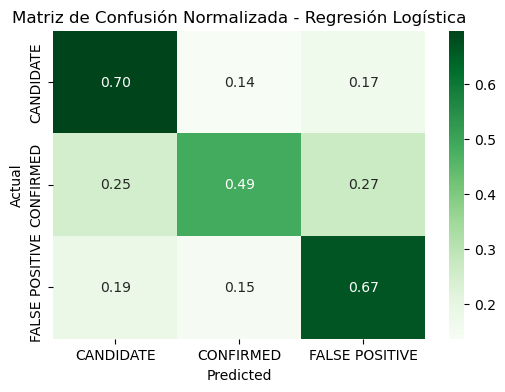

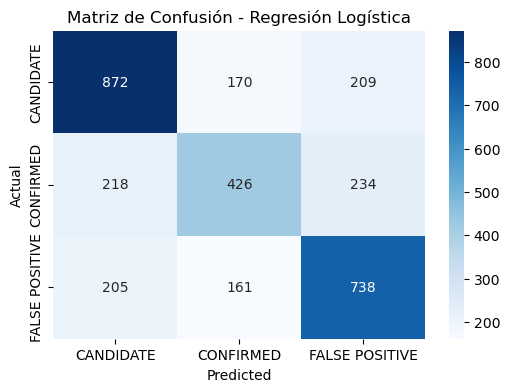

--------------------------------------------------
🔹 Bosque Aleatorio
   Exactitud: 0.7420
   Reporte:
                precision    recall  f1-score   support

     CANDIDATE       0.71      0.76      0.73      1251
     CONFIRMED       0.73      0.71      0.72       878
FALSE POSITIVE       0.79      0.74      0.77      1104

      accuracy                           0.74      3233
     macro avg       0.75      0.74      0.74      3233
  weighted avg       0.74      0.74      0.74      3233



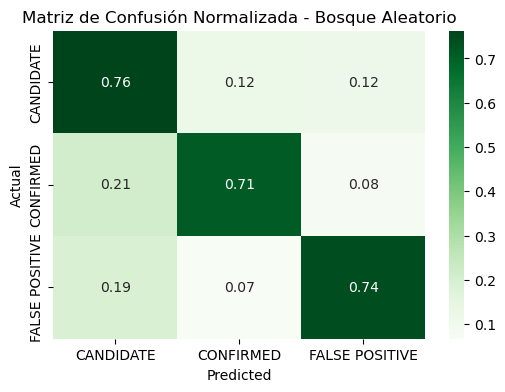

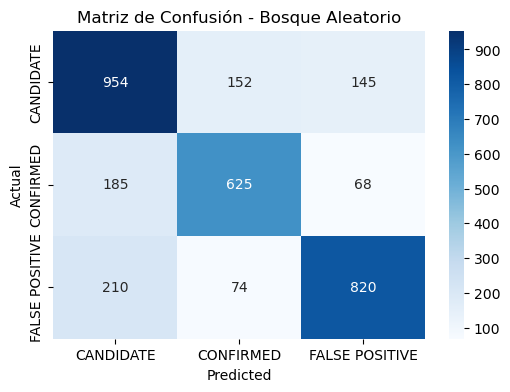

--------------------------------------------------
🔹 SVM
   Exactitud: 0.6564
   Reporte:
                precision    recall  f1-score   support

     CANDIDATE       0.68      0.69      0.69      1251
     CONFIRMED       0.60      0.53      0.56       878
FALSE POSITIVE       0.67      0.71      0.69      1104

      accuracy                           0.66      3233
     macro avg       0.65      0.65      0.65      3233
  weighted avg       0.65      0.66      0.65      3233



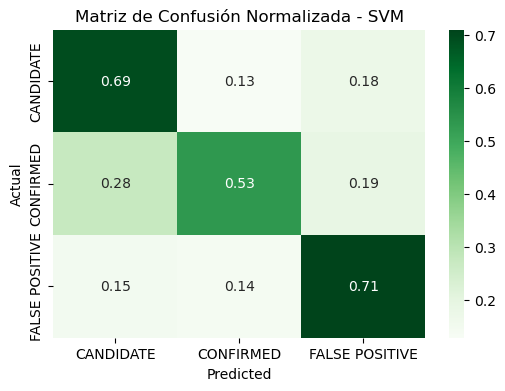

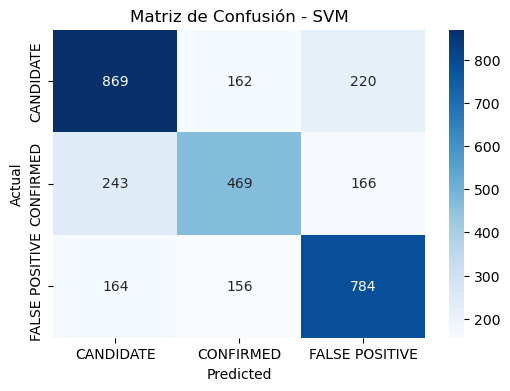

--------------------------------------------------
🔹 KNN
   Exactitud: 0.6180
   Reporte:
                precision    recall  f1-score   support

     CANDIDATE       0.62      0.68      0.65      1251
     CONFIRMED       0.54      0.56      0.55       878
FALSE POSITIVE       0.70      0.59      0.64      1104

      accuracy                           0.62      3233
     macro avg       0.62      0.61      0.61      3233
  weighted avg       0.62      0.62      0.62      3233



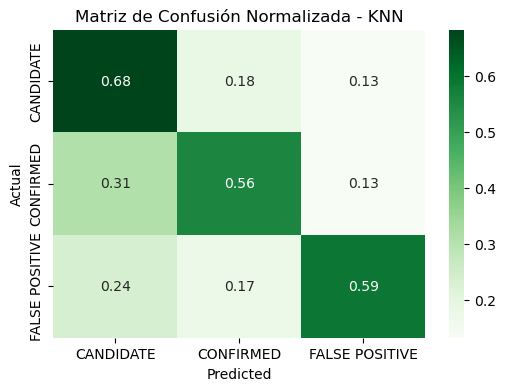

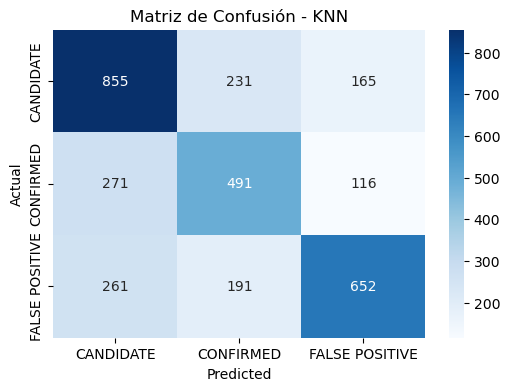

--------------------------------------------------


In [233]:
# --- 5️⃣ Definir modelos a comparar ---
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Bosque Aleatorio": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

# --- 6️⃣ Entrenar y evaluar ---
n_classes = len(disposition_norm_classes)
class_labels = list(range(n_classes))  # Etiquetas numéricas: [0, 1, ..., n-1]

le_status = label_encoders['disposition_norm']
disposition_norm_classes = le_status.classes_
class_labels = list(range(len(disposition_norm_classes)))  # [0, 1, ..., n-1]

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    
    print(f"🔹 {name}")
    print(f"   Exactitud: {acc:.4f}")
    
    # Corregido: Especificar labels para manejar clases faltantes en test
    report = classification_report(y_test, preds, target_names=disposition_norm_classes, 
                                   labels=class_labels, zero_division=0)
    print(f"   Reporte:\n{report}")

    # Corregido: Especificar labels para matriz de confusión completa
    cm = confusion_matrix(y_test, preds, labels=class_labels)
    # Matriz normalizada (%)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)  # Evitar división por cero
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=disposition_norm_classes, yticklabels=disposition_norm_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión Normalizada - {name}')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=disposition_norm_classes, yticklabels=disposition_norm_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()
    print("-" * 50)

c:\Users\anala\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔹 Red Neuronal Simple
   Exactitud: 0.6527
   Reporte:
              precision    recall  f1-score   support

         APC       0.00      0.00      0.00       109
          CP       0.60      0.67      0.63      1157
          FA       0.00      0.00      0.00        18
          FP       0.70      0.74      0.72      1628
          KP       0.51      0.10      0.17       172
          PC       0.65      0.66      0.65      1765
     REFUTED       0.00      0.00      0.00         0

    accuracy                           0.65      4849
   macro avg       0.35      0.31      0.31      4849
weighted avg       0.63      0.65      0.64      4849



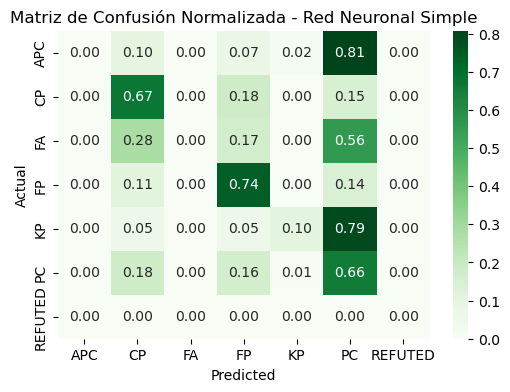

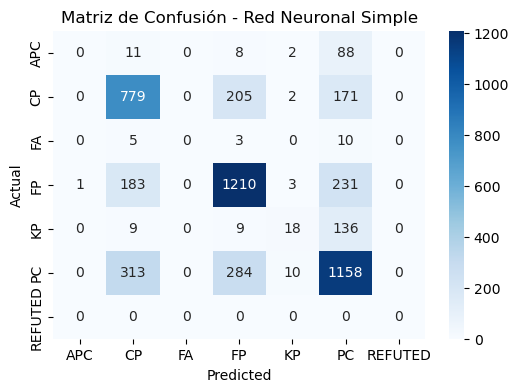

--------------------------------------------------
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔹 Red Neuronal Media
   Exactitud: 0.6616
   Reporte:
              precision    recall  f1-score   support

         APC       0.33      0.01      0.02       109
          CP       0.63      0.66      0.64      1157
          FA       0.00      0.00      0.00        18
          FP       0.71      0.76      0.73      1628
          KP       0.55      0.20      0.29       172
          PC       0.64      0.67      0.66      1765
     REFUTED       0.00      0.00      0.00         0

    accuracy                           0.66      4849
   macro avg       0.41      0.33      0.33      4849
weighted avg       0.65      0.66      0.65      4849



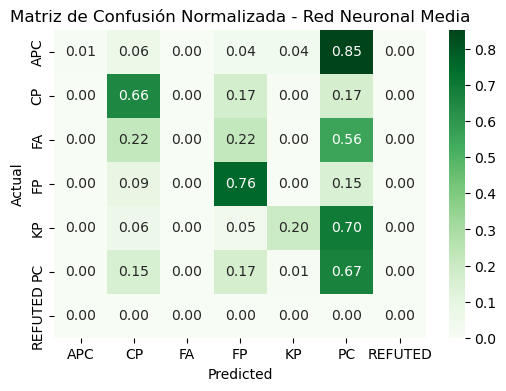

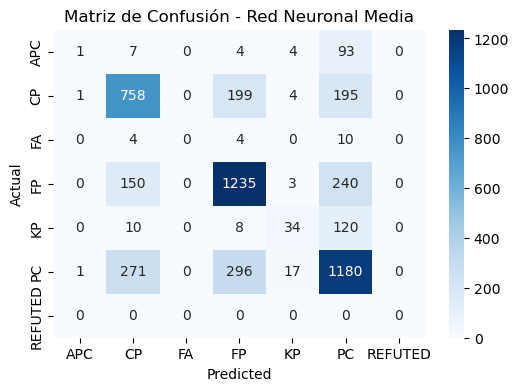

--------------------------------------------------
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔹 Red Neuronal Profunda
   Exactitud: 0.6626
   Reporte:
              precision    recall  f1-score   support

         APC       0.22      0.02      0.03       109
          CP       0.61      0.74      0.67      1157
          FA       0.67      0.11      0.19        18
          FP       0.76      0.71      0.73      1628
          KP       0.40      0.19      0.25       172
          PC       0.64      0.66      0.65      1765
     REFUTED       0.00      0.00      0.00         0

    accuracy                           0.66      4849
   macro avg       0.47      0.35      0.36      4849
weighted avg       0.65      0.66      0.65      4849



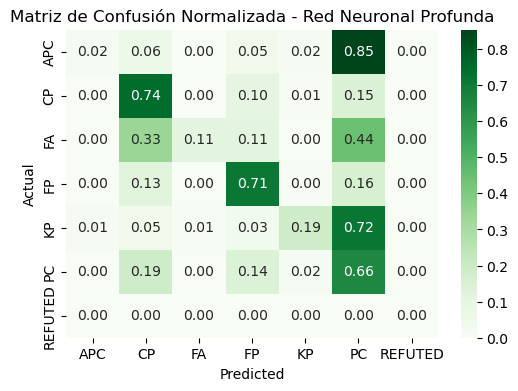

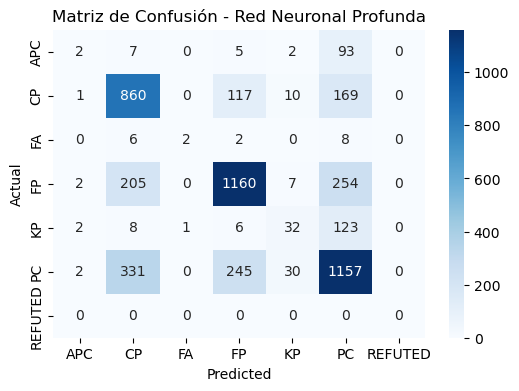

--------------------------------------------------
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
🔹 Red con Dropout
   Exactitud: 0.6564
   Reporte:
              precision    recall  f1-score   support

         APC       0.00      0.00      0.00       109
          CP       0.58      0.76      0.66      1157
          FA       0.00      0.00      0.00        18
          FP       0.75      0.71      0.73      1628
          KP       0.50      0.01      0.01       172
          PC       0.64      0.65      0.65      1765
     REFUTED       0.00      0.00      0.00         0

    accuracy                           0.66      4849
   macro avg       0.35      0.30      0.29      4849
weighted avg       0.64      0.66      0.64      4849



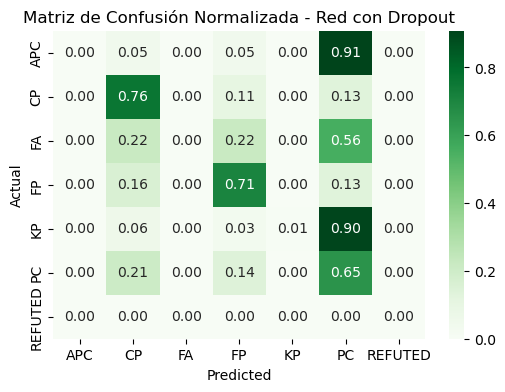

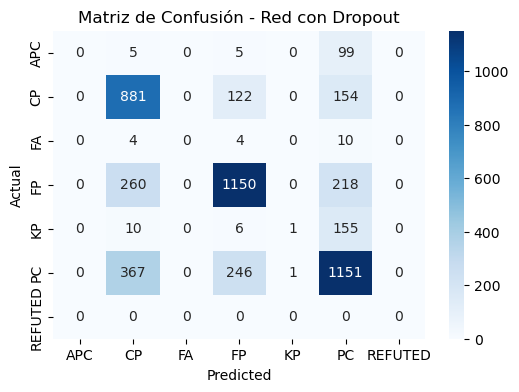

--------------------------------------------------


In [ ]:
# --- Imports adicionales para redes neuronales (agregar al inicio de tu script) ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import numpy as np

# --- Configuración para reproducibilidad (opcional, agregar al inicio) ---
tf.random.set_seed(42)
np.random.seed(42)

# --- Ejemplo de DataFrame (reemplázalo por tu archivo CSV) ---
data = cleaned.copy()

# --- 1️⃣ Convertir columnas categóricas a numéricas ---
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Guardamos las clases de la variable objetivo (corregido: verificar si fue codificado)
if 'Status' in label_encoders:
    status_classes = label_encoders['Status'].classes_
else:
    # En caso de que ya sea numérico, creamos etiquetas genéricas
    status_classes = [str(cls) for cls in sorted(data['Status'].unique())]

# --- 2️⃣ Separar variables predictoras y variable objetivo ---
X = data.drop('Status', axis=1)
y = data['Status']

# --- 3️⃣ Normalizar las variables numéricas ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4️⃣ Dividir datos para entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# --- 5️⃣ Definir modelos de redes neuronales a comparar ---
# Configuramos variantes de redes neuronales (MLP simples)
n_features = X_train.shape[1]
n_classes = len(status_classes)

def create_nn_model(architecture='simple', learning_rate=0.001):
    model = Sequential()
    if architecture == 'simple':
        # Red simple: 1 capa oculta
        model.add(Dense(64, input_dim=n_features, activation='relu'))
        model.add(Dense(n_classes, activation='softmax'))
    elif architecture == 'medium':
        # Red media: 2 capas ocultas
        model.add(Dense(128, input_dim=n_features, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(n_classes, activation='softmax'))
    elif architecture == 'deep':
        # Red profunda: 3 capas ocultas
        model.add(Dense(256, input_dim=n_features, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(n_classes, activation='softmax'))
    elif architecture == 'with_dropout':
        # Red con dropout adicional
        model.add(Dense(128, input_dim=n_features, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(n_classes, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

nn_models = {
    "Red Neuronal Simple": create_nn_model('simple'),
    "Red Neuronal Media": create_nn_model('medium'),
    "Red Neuronal Profunda": create_nn_model('deep'),
    "Red con Dropout": create_nn_model('with_dropout')
}

# --- 6️⃣ Entrenar y evaluar ---
class_labels = list(range(n_classes))  # Etiquetas numéricas: [0, 1, ..., n-1]

for name, model in nn_models.items():
    # Entrenamiento con validación (usamos 20% de train para validación)
    # Corregido: Removido 'random_state' de fit(), ya que no es un parámetro válido en Keras
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                        verbose=0)  # verbose=0 para no mostrar progreso detallado
    
    # Predicciones
    preds_probs = model.predict(X_test)
    preds = np.argmax(preds_probs, axis=1)
    
    # Exactitud
    acc = accuracy_score(y_test, preds)
    
    print(f"🔹 {name}")
    print(f"   Exactitud: {acc:.4f}")
    
    # Reporte de clasificación
    report = classification_report(y_test, preds, target_names=status_classes, 
                                   labels=class_labels, zero_division=0)
    print(f"   Reporte:\n{report}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, preds, labels=class_labels)
    # Matriz normalizada (%)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-8)  # Evitar división por cero
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=status_classes, yticklabels=status_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión Normalizada - {name}')
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=status_classes, yticklabels=status_classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Matriz de Confusión - {name}')
    plt.show()
    print("-" * 50)

# Opcional: Liberar memoria de los modelos si es necesario
# for model in nn_models.values():
#     del model
# tf.keras.backend.clear_session()

C:\Users\anala\AppData\Local\Temp\ipykernel_18660\1718559521.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = le.fit_transform(data[col])
C:\Users\anala\AppData\Local\Temp\ipykernel_18660\1718559521.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = le.fit_transform(data[col])


🔹 Regresión Logística
   Exactitud: 0.6020
   Reporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.55      0.51      0.53      1157
           2       0.00      0.00      0.00        18
           3       0.61      0.70      0.65      1628
           4       0.00      0.00      0.00       172
           5       0.62      0.67      0.65      1765

    accuracy                           0.60      4849
   macro avg       0.30      0.31      0.30      4849
weighted avg       0.56      0.60      0.58      4849



c:\Users\anala\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anala\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anala\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


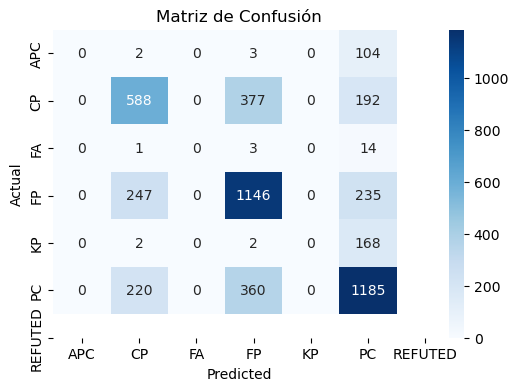

--------------------------------------------------
🔹 Bosque Aleatorio
   Exactitud: 0.7084
   Reporte:
              precision    recall  f1-score   support

           0       0.15      0.02      0.03       109
           1       0.72      0.71      0.72      1157
           2       0.00      0.00      0.00        18
           3       0.76      0.75      0.76      1628
           4       0.71      0.35      0.47       172
           5       0.66      0.75      0.70      1765

    accuracy                           0.71      4849
   macro avg       0.50      0.43      0.45      4849
weighted avg       0.70      0.71      0.70      4849



c:\Users\anala\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anala\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\anala\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


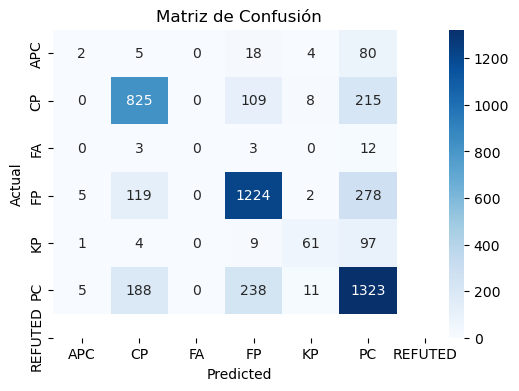

--------------------------------------------------


KeyboardInterrupt: 

In [ ]:
# --- Ejemplo de DataFrame (reemplázalo por tu archivo CSV) ---
data = cleaned

# --- 1️⃣ Convertir columnas categóricas a numéricas ---
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Guarda las clases de Status antes de eliminarla de X
status_classes = label_encoders['Status'].classes_

# --- 2️⃣ Separar variables predictoras y variable objetivo ---
X = data.drop('Status', axis=1)
y = data['Status']

# --- 3️⃣ Normalizar las variables numéricas ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 4️⃣ Dividir datos para entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# --- 5️⃣ Definir modelos a comparar ---
models = {
    "Regresión Logística": LogisticRegression(max_iter=1000),
    "Bosque Aleatorio": RandomForestClassifier(random_state=42),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier()
}

# --- 6️⃣ Entrenar y evaluar ---
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    print(f"🔹 {name}")
    print(f"   Exactitud: {acc:.4f}")
    print(f"   Reporte:\n{classification_report(y_test, preds)}")
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Matriz de Confusión')
    plt.show()
    print("-" * 50)

In [ ]:
tess.tfopwg_disp.value_counts()

AttributeError: 'DataFrame' object has no attribute 'tfopwg_disp'

In [ ]:
k2.disposition.value_counts()

disposition
CONFIRMED         2315
CANDIDATE         1374
FALSE POSITIVE     293
REFUTED             22
Name: count, dtype: int64

In [ ]:
kepler.koi_disposition.value_counts()

koi_disposition
FALSE POSITIVE    4839
CONFIRMED         2746
CANDIDATE         1979
Name: count, dtype: int64